# Background

### Business Objectives
The goal of the project is to use machine learning to also understand how dstributor/customer behavior metrics drove revenue in a flexible way. Explanations can be taken upstream to c-suite to understand customer behavior for the whole business, and it can be taken downstream to account managers for tacticle interventions for their specific set of accounts.

### Technical Overview
This project uses XGboost to train a multivariate model to make predictions about revenue, based on distibutors and customer behavior metrics. Cross-validation using CV grid search was used to tune the model, and explainability of the model was generated using SHAP values to understand feature importance, both at a local and global level (i.e individual distributor, and across all distributors). 



In [3]:
%pip install xgboost
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Install Packages and Dependencies

In [4]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap as shap
from google.cloud import bigquery
import time
from datetime import datetime


/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [5]:
import time
projectstart = time.time()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = f'./Runs/{timestamp}'

# Prep & Explore Data

 ## Prepare Data

### Read in Dataset

In [7]:
df = pd.read_csv('distributors.csv')

In [8]:
features=['new_customers', 'repeat_customers',
       'requests_for_quotes', 'months_purchased',
       'contract_renewals', 'customer_retention', 'order_value',
       'number_orders', 'employees']

attributes=['year', 'distributor_id', 'distributor', 'segment', 'company']

target=['revenue']

In [9]:
#Create datasets with target + features, just features, and just target.
df_attributes_target_features = df.filter(attributes + target + features)
df_target_features = df.filter(target + features)
df_features = df.filter(features)
df_target = df.filter(target)

### Descriptive Stats across all distributors

In [10]:
# Descriptive stats for all distributors
df_stats_market = df_target_features.describe().drop('count').transpose()
df_stats_market

,mean,std,min,25%,50%,75%,max
revenue,6.200882e+06,9.319182e+06,646463.278495,646463.278495,3.300125e+06,7.248050e+06,7.326136e+07
new_customers,6.941673e+01,1.195624e+02,0.600000,0.600000,2.774725e+01,8.179743e+01,8.135833e+02
repeat_customers,9.136095e+02,1.507709e+03,53.300000,53.300000,4.764717e+02,1.120372e+03,1.131158e+04
requests_for_quotes,1.071554e+03,1.860104e+03,6.000000,6.000000,5.360000e+02,1.120000e+03,1.184100e+04
months_purchased,6.744519e+00,1.176027e+00,2.703909,6.110433,6.319037e+00,7.595256e+00,8.962240e+00
contract_renewals,3.170783e+02,6.185773e+02,5.000000,5.000000,1.180000e+02,3.280000e+02,3.568000e+03
customer_retention,2.702631e+03,4.556249e+03,54.000000,54.000000,1.084000e+03,2.174000e+03,2.041600e+04
order_value,1.417744e+06,2.313268e+06,160282.600000,160282.600000,4.047126e+05,2.074168e+06,2.041900e+07
number_orders,1.941794e+04,4.410139e+04,1757.000000,1757.000000,1.757000e+03,1.699800e+04,2.926130e+05
employees,1.265868e+04,1.774874e+04,509.000000,2840.000000,9.340000e+03,1.443000e+04,1.097290e+05


### Median descriptive stats grouped by segment

In [11]:
# Descriptive stats for Segments
df_stats_cluster = df.groupby(['segment'])[target + features].median().transpose()
df_stats_cluster

segment,Segment 1,Segment 2,Segment 3,Segment 4,Segment 5,Segment 6
revenue,3.566496e+06,2.653373e+06,3.361560e+06,4.079103e+06,3.277701e+06,2.892372e+06
new_customers,3.346534e+01,2.302326e+01,3.309837e+01,2.165947e+01,2.824069e+01,3.043333e+01
repeat_customers,4.262716e+02,4.995370e+02,5.456241e+02,4.693353e+02,5.200359e+02,3.905273e+02
requests_for_quotes,4.280000e+02,6.010000e+02,5.870000e+02,5.230000e+02,4.840000e+02,6.175000e+02
months_purchased,6.338517e+00,6.296832e+00,6.280021e+00,6.333791e+00,6.327426e+00,6.308748e+00
contract_renewals,1.340000e+02,1.325000e+02,9.700000e+01,1.200000e+02,1.140000e+02,1.250000e+02
customer_retention,8.190000e+02,7.155000e+02,1.068000e+03,1.025000e+03,1.158000e+03,1.100000e+03
order_value,1.602826e+05,1.602826e+05,2.903666e+05,3.299278e+05,5.957199e+05,5.242668e+05
number_orders,1.757000e+03,1.757000e+03,1.757000e+03,1.757000e+03,1.757000e+03,1.757000e+03
employees,8.787500e+03,8.794500e+03,9.169000e+03,8.961000e+03,1.000500e+04,8.678500e+03


### Median descriptive stats grouped by segment

In [12]:
# Descriptive stats for by company
pd.set_option('display.max_rows', None)
df_stats_loa = df.groupby(['company'])[target + features].median().transpose()
df_stats_loa

company,"Acevedo, Chavez and Gomez","Acosta, Mccann and Vaughn",Adams LLC,Adams and Sons,"Adams, Hays and Smith","Adams, Rice and Martinez","Adams, Riley and Vargas","Adams, Rowland and Roberts",Adams-Fields,Adams-Reed,...,Young-Phillips,Young-Smith,Yu Group,"Yu, Crane and Wood",Zamora-Russell,Zavala Ltd,"Zimmerman, Patrick and Hoffman","Zimmerman, Sanchez and Burgess",Zimmerman-Yang,"Zuniga, Scott and Wheeler"
revenue,9.779132e+06,1.209700e+06,646463.278495,5.427913e+06,1.259365e+06,6.464633e+05,1.416630e+06,7.074573e+06,7.310777e+06,7.117669e+06,...,4.350923e+07,1.281200e+07,5.499703e+06,4.282623e+06,646463.278495,9.736719e+06,7.608525e+06,3.181475e+06,646463.278495,2.515520e+06
new_customers,6.887252e+01,1.717715e+01,0.600000,5.389843e+01,3.488367e+02,6.000000e-01,6.000000e-01,7.301141e+01,1.612950e+01,4.927426e+01,...,4.381422e+02,1.758675e+02,6.000000e-01,1.492439e+02,81.770706,1.745637e+02,8.517368e+00,2.471484e+01,12.958048,2.784628e+01
repeat_customers,1.131158e+04,1.336903e+03,53.300000,6.732095e+01,6.265836e+02,6.903857e+02,4.118731e+02,5.330000e+01,5.330000e+01,1.901190e+03,...,1.114481e+03,3.236749e+02,2.413514e+03,2.581994e+02,463.500566,1.344836e+03,5.925722e+02,5.752571e+02,1234.960366,7.362076e+02
requests_for_quotes,1.812000e+03,9.801000e+03,493.000000,4.583500e+03,1.227000e+03,6.000000e+00,8.810000e+02,1.052000e+03,6.000000e+00,6.000000e+00,...,3.374000e+03,8.200000e+01,9.480000e+02,3.590000e+02,286.000000,1.303000e+03,2.181000e+03,6.000000e+00,728.000000,2.503000e+03
months_purchased,2.703909e+00,6.312286e+00,6.311697,6.710287e+00,8.962240e+00,6.284530e+00,8.962240e+00,6.055899e+00,8.444881e+00,6.073443e+00,...,7.441221e+00,7.493347e+00,5.998768e+00,7.187529e+00,6.341351,7.216916e+00,7.090343e+00,7.157744e+00,8.962240,4.958171e+00
contract_renewals,2.800000e+02,5.000000e+00,584.000000,2.940000e+02,1.760000e+02,7.600000e+02,5.000000e+00,2.600000e+02,8.600000e+01,2.950000e+02,...,5.000000e+00,1.940000e+02,1.010000e+03,9.600000e+01,5.000000,5.000000e+00,8.240000e+02,5.000000e+00,5.000000,3.550000e+02
customer_retention,5.400000e+01,4.110000e+02,54.000000,7.805000e+02,5.400000e+01,6.420000e+02,2.893000e+03,5.400000e+01,2.097000e+03,5.810000e+02,...,5.400000e+01,7.347000e+03,7.553000e+03,4.364000e+03,54.000000,5.400000e+01,5.590000e+03,5.710000e+02,54.000000,5.965000e+03
order_value,1.602826e+05,1.602826e+05,160282.600000,1.575955e+06,1.602826e+05,1.816646e+06,4.606050e+05,1.602826e+05,2.655620e+06,2.655569e+06,...,8.108708e+05,6.232705e+05,3.711876e+06,2.477751e+06,160282.600000,1.602826e+05,2.808308e+06,1.902118e+06,160282.600000,1.515612e+06
number_orders,4.987400e+04,3.849000e+04,1757.000000,1.757000e+03,1.757000e+03,1.736900e+04,1.757000e+03,1.757000e+03,4.761900e+04,2.926130e+05,...,3.216500e+04,2.610000e+03,1.757000e+03,3.816800e+04,24471.000000,2.738550e+05,1.757000e+03,1.757000e+03,1757.000000,1.757000e+03
employees,2.513600e+04,1.080800e+04,9716.000000,5.071100e+04,5.090000e+02,5.090000e+02,4.833000e+03,5.090000e+02,1.148400e+04,5.355000e+03,...,8.006000e+03,1.252000e+04,5.090000e+02,1.595100e+04,13035.000000,5.090000e+02,6.139000e+03,8.507000e+03,1618.000000,5.090000e+02


# Train Model

Next, we train our model. One-hot encoding not required, since there are no categorical variables.
Hyperparemeter tuning was done with crossvalidation first using RandomizedSearchCV, then further tuned using by exhaustive GridSearchCV across multiple parameters. We tune the following parameters:
- max_depth
- learning_rate
- min_child_weight
- gamma
- colsample_bytree
- subsample

In [13]:
X = df_features
y = df_target['revenue'].array

#set train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Log transform the target variable #not used in this model, just kept for use
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

## Hyperparameter Tuning: Grid Search

We use Grid Search CV to do crossvalidation across a selected parameter space. Each crossvalidation run uses k=10 folds. Crossvalidation logs is saved to prevent the need for recreation

In [14]:
# Create an XGBoost regressor
model = xgb.XGBRegressor(eval_metric='mape')

#set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              #"n_estimators": [300, 400, 500],
              "learning_rate": [0.005, 0.01, 0.015],
              'min_child_weight': [1, 5, 10],  #suggested for overfitting
              'gamma': [0.5, 1.5, 3],    #suggested for overfitting  #ran to here in prior model 
              'colsample_bytree': [0.8, 1.0],  #,  #added, #suggested for overfitting
              'subsample': [0.5, 0.8, 1.0]  #added, #suggested for overfitting
             }
# #The best hyperparameters are  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 1.0}

start_time = time.time()

# try out every combination of the above values
grid_model = GridSearchCV(model, param_grid, cv=10, return_train_score=True, n_jobs=-1).fit(X_train, y_train)
#grid_model = RandomizedSearchCV(model, param_grid, cv=10, return_train_score=True).fit(X_train, y_train)


print("The best hyperparameters are ",grid_model.best_params_)
# End measuring time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Grid search took {elapsed_time} seconds".format(elapsed_time))

#save results from GridSearchCV into a log file

import pandas as pd
import os
from datetime import datetime

# Create a directory for saving the results
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Generate a unique filename with a timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
file_name = os.path.join(log_dir, f"grid_search_results_{timestamp}.csv")

# Convert the results array to a DataFrame
results_df = pd.DataFrame(grid_model.cv_results_).sort_values(by = 'rank_test_score')


#Create a csv
import os
os.makedirs(output_folder, exist_ok=True)
output_file_path = os.path.join(output_folder, f'results_df_{timestamp}.csv')
results_df.to_csv(output_file_path, index=False)
print(f"CSV file saved at: {output_file_path}")

# Print the file path where the results are saved
print("Results saved to:", file_name)


The best hyperparameters are  {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.015, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5}
Grid search took 322.01 seconds
CSV file saved at: ./Runs/20231214_032759/results_df_20231214033322.csv
Results saved to: logs/grid_search_results_20231214033322.csv


### Fit XGBoost Regressor and Output Evaluation Metrics

XGBoost Model is fitted using the best crossvalidation hyperparameters. Various metrics are computed, such as mae, mape, mse, and rmse.

In [15]:
#now use the best parameters
from xgboost import XGBRegressor
{'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.015, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5}
model = XGBRegressor(max_depth=4, 
                     learning_rate=0.015, 
                     n_estimators=800,
                     colsample_bytree= 1.0, 
                     gamma=0.5, 
                     min_child_weight=10, 
                     subsample=0.5,
                     random_state=0,
                    booster='gbtree')

# model = xgb.XGBRegressor(eval_metric='mape')
# model.set_params(**grid_model.best_params_, random_state=0)

#Creating the model on Training Data
xgb_model=model.fit(X_train,y_train)
prediction_train=xgb_model.predict(X_train)
prediction_test=xgb_model.predict(X_test)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print('Mean Absolute Percent Error (MAPE):', mape)
print('R2 Value train:',metrics.r2_score(y_train, xgb_model.predict(X_train)))
print('R2 Value test:',metrics.r2_score(y_test, xgb_model.predict(X_test)))
print('Accuracy train',100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100))
print('Accuracy test',100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100))
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)


Mean Absolute Percent Error (MAPE): 2.4706161788416843
R2 Value train: 0.48386194477076505
R2 Value test: 0.05290383132613086
Accuracy train -94.52040494462628
Accuracy test -147.0616178841684
Mean Absolute Error (MAE): 5329137.001295163
Root Mean Squared Error (RMSE): 9180770.311275357


### Perform Secondary Cross Validation (6 folds)
Secondary cross validation is computed with final model.

In [16]:
#perform cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=6, random_state=0,shuffle=True)
results = cross_val_score(model, X, y, cv=kfold)
pd.DataFrame(results)

,0
0,0.015697
1,0.076641
2,0.084242
3,0.114753
4,0.111470
5,0.015863


### Create prediction dataset

In [17]:
y_full_pred = xgb_model.predict(X)
evaluation = pd.DataFrame({'Actuals': y.to_numpy().flatten(), 'Predicted': y_full_pred.flatten()})
test_index = X_test.index

evaluation['Error'] = evaluation['Predicted']-evaluation['Actuals']
evaluation['Pct Error'] = evaluation['Error']/evaluation['Actuals']
evaluation['Test'] = evaluation.index.isin(test_index)

eval_df = df_attributes_target_features.join(evaluation)
eval_df['rev_rank'] = eval_df['revenue'].rank(ascending = False)

### Visualize Results
Next, we plot our errors between predicted and actuals to visualize our results and look for outliers. For the sake of the notebook, only first 100 results are output.

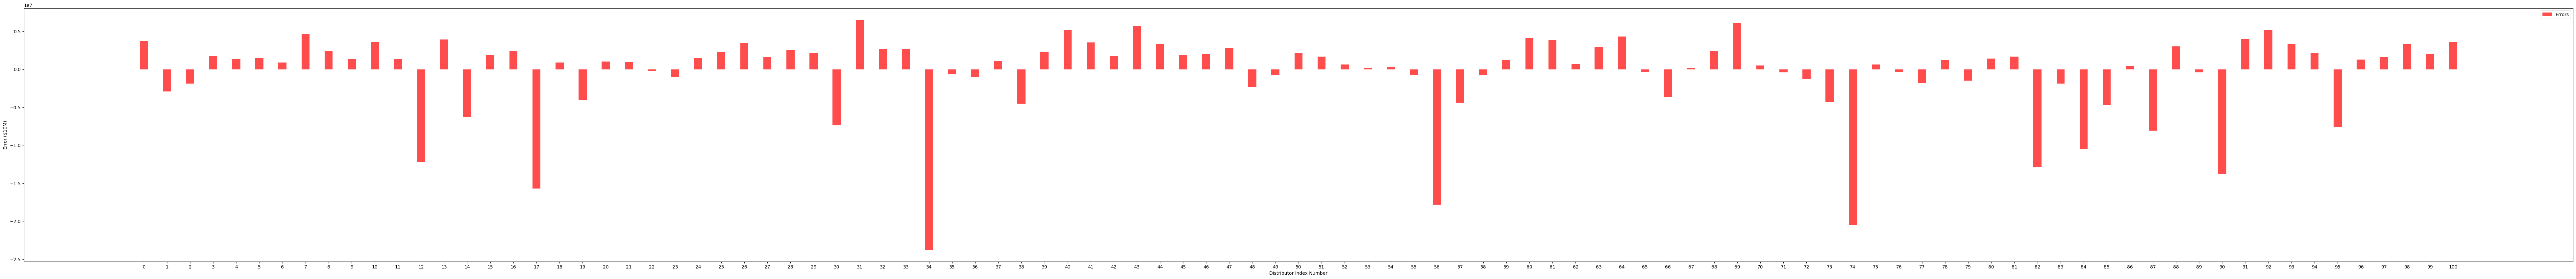

In [53]:
import matplotlib.pyplot as plt
import numpy as np

eval_df_sample = eval_df.loc[0:100]

plt.figure(figsize=(100, 10))

# Create bar positions
bar_positions = np.arange(len(eval_df_sample['Error']))

# Create bar width
bar_width = 0.35

plt.bar(bar_positions, eval_df_sample['Error'], bar_width, label='Errors', color='r', alpha=0.7)

plt.xticks(bar_positions, eval_df_sample.index)  # Set x-axis labels

plt.ylabel('Error ($10M)')
plt.xlabel('Distributor Index Number')
plt.legend(loc='best')
    
    
plt.show()


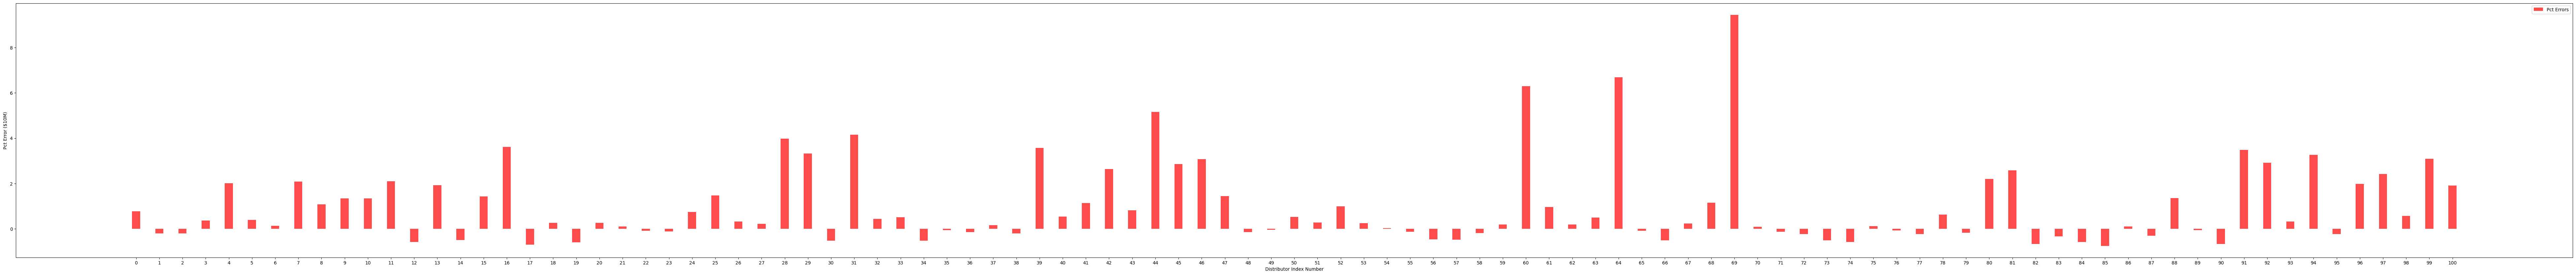

In [54]:

plt.figure(figsize=(100, 10))

# Create bar positions
bar_positions = np.arange(len(eval_df_sample['Pct Error']))

# Create bar width
bar_width = 0.35

plt.bar(bar_positions, eval_df_sample['Pct Error'], bar_width, label='Pct Errors', color='r', alpha=0.7)

plt.xticks(bar_positions, eval_df_sample.index)  # Set x-axis labels

plt.ylabel('Pct Error ($10M)')
plt.xlabel('Distributor Index Number')
plt.legend(loc='best')
    
    
plt.show()


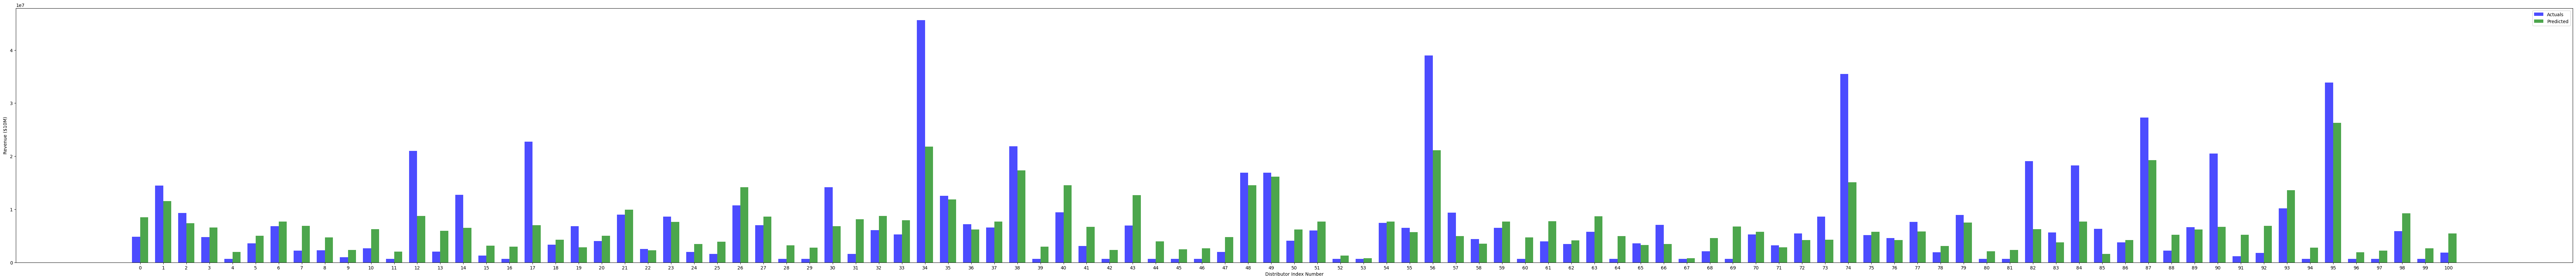

In [55]:
plt.figure(figsize=(100, 10))

# Create bar positions
bar_positions = np.arange(len(eval_df_sample))

# Create bar width
bar_width = 0.35

plt.bar(bar_positions, eval_df_sample["Actuals"], bar_width, label='Actuals', color='b', alpha=0.7)
plt.bar(bar_positions + bar_width, eval_df_sample["Predicted"], bar_width, label='Predicted', color='g', alpha=0.7)

plt.xticks(bar_positions + bar_width / 2, eval_df_sample.index)  # Set x-axis labels

plt.ylabel('Revenue ($10M)')
plt.xlabel('Distributor Index Number')
plt.legend(loc='best')

# test_index = X_test.index
# for i in test_index:
#     plt.annotate('Test',
#                  (eval_df_sample.index[i], eval_df_sample['Predicted'][i]),
#                  xytext=(15, 15), 
#                  textcoords='offset points',
#                  arrowprops=dict(arrowstyle='-|>'))


plt.show()


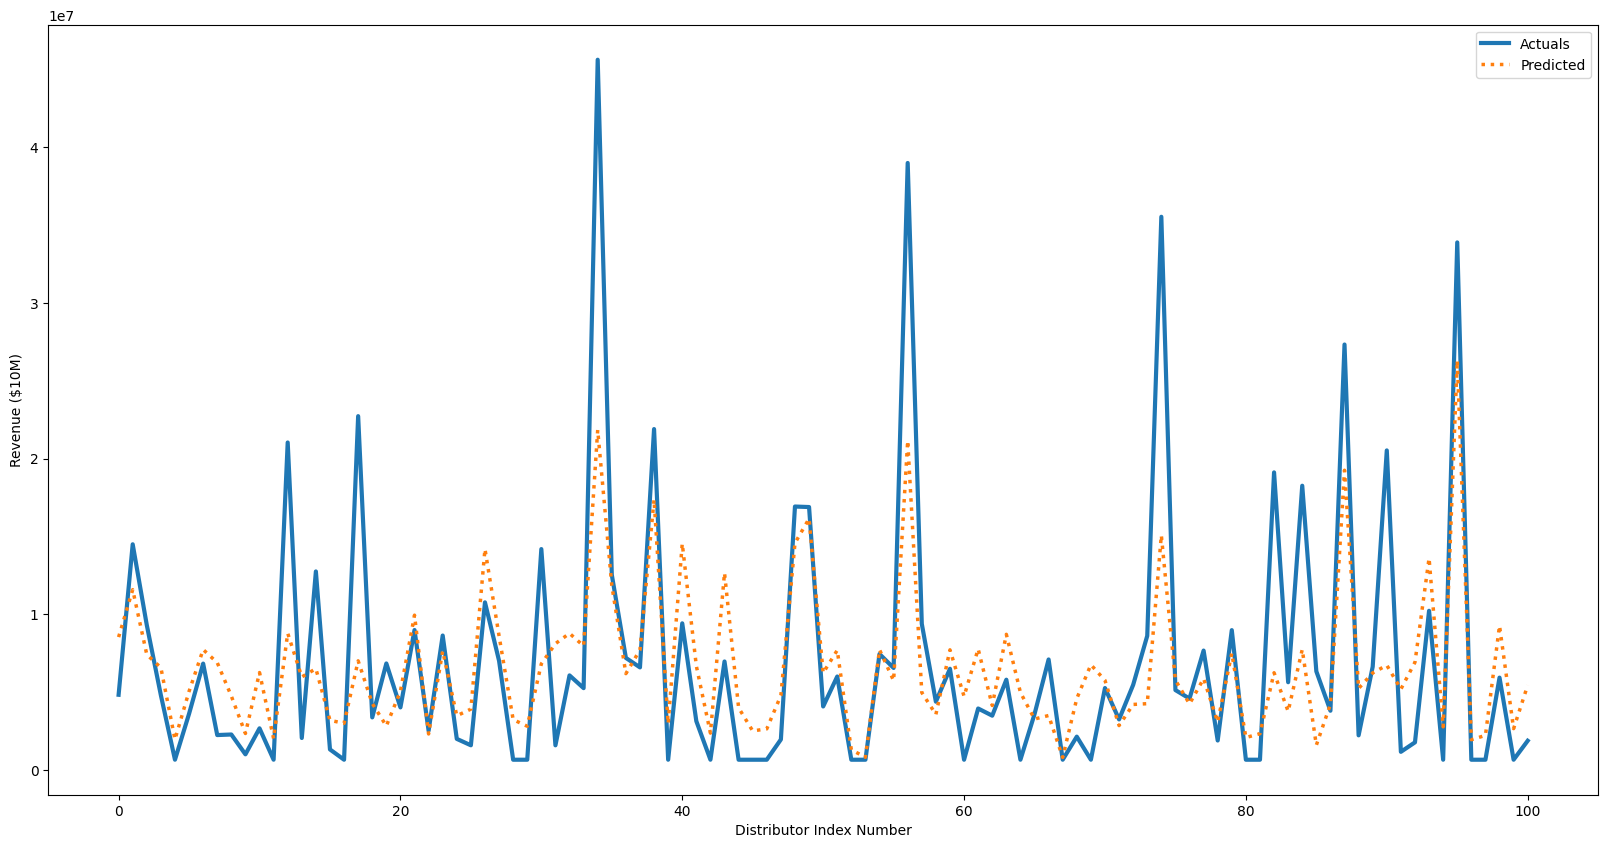

In [57]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20,10))
plt.plot(eval_df_sample["Actuals"],label='Actuals',linewidth = 3)
plt.plot(eval_df_sample["Predicted"], label = 'Predicted', linestyle = 'dotted',linewidth = 2.5)


test_index = X_test.index
# for i in test_index:
#     plt.annotate('Test',
#                  (eval_df_sample.index[i], eval_df_sample['Predicted'][i]),
#                  xytext=(15, 15), 
#                  textcoords='offset points',
#                  arrowprops=dict(arrowstyle='-|>'))
plt.ylabel('Revenue ($10M)')
plt.xlabel('Distributor Index Number')
plt.legend(loc='best')

plt.show()

In [22]:

# Create a csv
import os
os.makedirs(output_folder, exist_ok=True)
output_file_path = os.path.join(output_folder, f'df_evaluation_{timestamp}.csv')
eval_df.to_csv(output_file_path, index=False)
print(f"CSV file saved at: {output_file_path}")

CSV file saved at: ./Runs/20231214_032759/df_evaluation_20231214033322.csv


In [61]:
eval_df.sort_values('Pct Error')

,year,distributor_id,distributor,segment,company,revenue,new_customers,repeat_customers,requests_for_quotes,months_purchased,...,customer_retention,order_value,number_orders,employees,Actuals,Predicted,Error,Pct Error,Test,rev_rank
298,2022,9627162474145,Jeremiah Frye,Segment 5,"Flores, Escobar and Davis",7.750510e+05,559.923277,253.364302,10711.0,8.962240,...,54.0,1.602826e+05,1757.0,8966.0,7.750510e+05,-1.191092e+06,-1.966143e+06,-2.536792,True,2135.0
212,2023,5449780744011,Hannah White,Segment 6,Campbell PLC,6.464633e+05,543.374542,53.300000,309.0,8.962240,...,1270.0,1.602826e+05,1757.0,7555.0,6.464633e+05,-7.886558e+05,-1.435119e+06,-2.219955,False,2619.5
1133,2023,4150152284189,Eugene Wilcox,Segment 1,Smith Ltd,6.464633e+05,297.198690,53.300000,6.0,8.962240,...,3827.0,1.602826e+05,1757.0,7019.0,6.464633e+05,-3.839092e+05,-1.030372e+06,-1.593861,False,2619.5
302,2022,9344849706404,Judith Sharp,Segment 3,Coleman Group,4.584987e+07,0.600000,1902.979964,756.0,6.203227,...,20416.0,1.602826e+05,1757.0,509.0,4.584987e+07,9.733709e+05,-4.487650e+07,-0.978770,True,44.0
2137,2023,3587642465727,Jared Dickson,Segment 5,"Burke, Gonzales and Johnson",4.584111e+07,0.600000,53.300000,257.0,8.508143,...,54.0,7.956269e+05,1757.0,509.0,4.584111e+07,3.508688e+06,-4.233242e+07,-0.923460,False,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580,2023,8237564752393,Timothy Solis,Segment 5,"Blake, Becker and Jordan",6.464633e+05,120.457506,53.300000,298.0,7.193648,...,7619.0,2.053333e+06,39504.0,3295.0,6.464633e+05,1.207810e+07,1.143163e+07,17.683346,True,2619.5
1349,2022,8519517053277,Anthony Ortiz,Segment 6,"Hayden, Calderon and Henderson",6.464633e+05,196.640773,566.494092,356.0,5.102230,...,970.0,5.631517e+06,1757.0,26996.0,6.464633e+05,1.212243e+07,1.147597e+07,17.751927,False,2619.5
553,2023,8370748709322,Heather Mendez,Segment 5,Goodman-Conley,6.464633e+05,127.764347,785.261248,951.0,6.233182,...,1179.0,3.812298e+05,144659.0,16098.0,6.464633e+05,1.371445e+07,1.306799e+07,20.214583,True,2619.5
2040,2022,2437492645026,Natalie Wright,Segment 5,Johnson-Evans,6.464633e+05,246.907024,2554.889695,564.0,6.204843,...,151.0,6.958970e+05,130949.0,4779.0,6.464633e+05,1.415839e+07,1.351193e+07,20.901312,False,2619.5


# Explain Model using SHAP Values

Let's visualize our results. We use SHAP explainer to visualize the impact of distributor/customer behavior metrics on revenue. The beeswarm plot shows the feature impacts on our whole business, while the waterfalls show impact on a specific distirbutor.

### Create SHAP explainer

In [24]:
#set up shap values with entire dataset
df_attributes = df.filter(attributes)
explainer = shap.Explainer(model)
shap_values = explainer(df_features)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Impact on whole business (Global explanations)
We see that new customers, followed by contract renewals, then number of orders, and order value were the highest impact metrics. Most of the metrics behave as expected, with the higher the metric value, the higher the impact on revenue. An exception is months_purchased, which seems to have less obvious behavior. Further work can be used to investigate this. There are also a number of distributors with low repeat customers but with postitively impacted revenue, which is interesting.

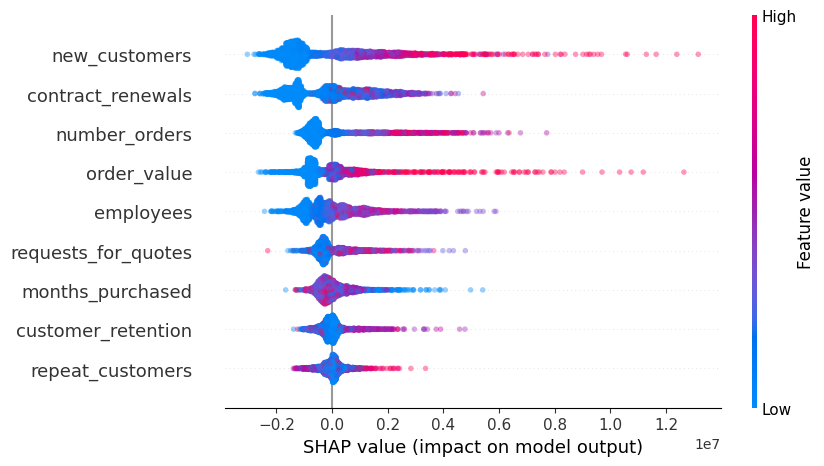

In [65]:
shap.plots.beeswarm(shap_values, alpha = 0.4)

## Impact on single distributor (local explanations)
The value in a tree-based model means that we can also see explanations at a localized level, i.e a single distributor, useful for tactical business decisions, such as account management. Here we see the tornado showing the impact of metrics on a single distributor's revenue, compared to the expected average across all distributors.

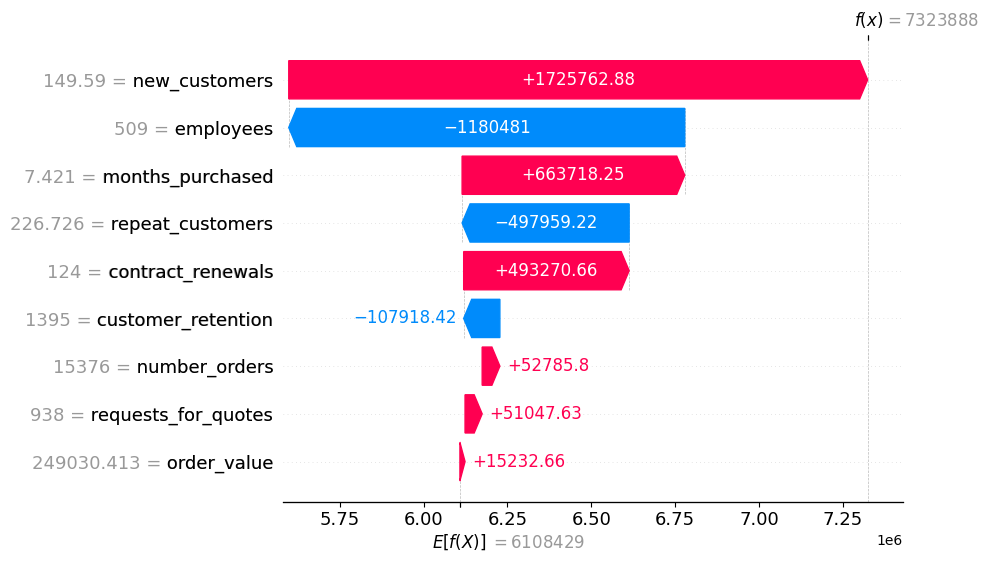

,183,50%,mean,Segment 6,Fisher-Thomas
year,2023,NaN,NaN,NaN,NaN
distributor_id,6914713598294,NaN,NaN,NaN,NaN
distributor,George Davidson,NaN,NaN,NaN,NaN
segment,Segment 6,NaN,NaN,NaN,NaN
company,Fisher-Thomas,NaN,NaN,NaN,NaN
revenue,6918455.997579,3.300125e+06,6.200882e+06,2.892372e+06,6.918456e+06
new_customers,149.58954,2.774725e+01,6.941673e+01,3.043333e+01,1.495895e+02
repeat_customers,226.725749,4.764717e+02,9.136095e+02,3.905273e+02,2.267257e+02
requests_for_quotes,938.0,5.360000e+02,1.071554e+03,6.175000e+02,9.380000e+02
months_purchased,7.421157,6.319037e+00,6.744519e+00,6.308748e+00,7.421157e+00


In [32]:
#Show waterfall plot
index = 183
shap.plots.waterfall(shap_values = shap_values[index] )

pd.DataFrame(df_attributes_target_features.iloc[index]).join(df_stats_market[['50%','mean']]).join(df_stats_cluster[[df.iloc[index].segment]]).join(df_stats_loa[[df.iloc[index].company]])

# Impact vs previous year performance

The previous waterfall chart was set up to be compare a distributor against the average across all distributors. But we can also manipulate the SHAP values to view something against their previous year's performance. Here's how we can wrangle the data to view SHAP values from a yearly perspective

In [26]:
#get shap values and relabel cols
df_shap = pd.DataFrame(shap_values.values)
shap_columns = [f'{feature}_impact' for feature in features]
df_shap.columns = shap_columns
df_shap.head()

,new_customers_impact,repeat_customers_impact,requests_for_quotes_impact,months_purchased_impact,contract_renewals_impact,customer_retention_impact,order_value_impact,number_orders_impact,employees_impact
0,3239092.000,-590215.000000,-848674.937500,-973452.187500,-2.255100e+06,464179.625000,6.148107e+04,3.701212e+06,-381836.750000
1,2319289.750,223339.890625,-688180.000000,-519972.968750,1.486191e+06,-670730.125000,8.589537e+03,2.599511e+06,705210.312500
2,1143882.125,-142061.296875,-480592.093750,-506733.093750,1.915767e+06,-703358.937500,1.146289e+06,-9.106399e+05,-169208.578125
3,-1507667.125,-567639.000000,-109142.656250,138273.640625,4.780359e+05,311078.843750,3.172624e+05,1.909764e+06,-518381.968750
4,-1108281.625,6411.936035,-218137.171875,573713.000000,-1.218963e+06,18653.216797,-7.314432e+05,-5.190075e+05,-962994.687500


In [27]:
#make dataframe containing attributes, targets, features, and shap values
df_attributes_target_features_shap = pd.concat([df_attributes_target_features, df_shap], axis =1)
df_attributes_target_features_shap.head()

# Create a csv
os.makedirs(output_folder, exist_ok=True)
output_file_path = os.path.join(output_folder, f'df_attributes_target_features_shap_{timestamp}.csv')
df_attributes_target_features_shap.to_csv(output_file_path, index=False)
print(f"CSV file saved at: {output_file_path}")

df_attributes_target_features_shap.head()

CSV file saved at: ./Runs/20231214_032759/df_attributes_target_features_shap_20231214033322.csv


,year,distributor_id,distributor,segment,company,revenue,new_customers,repeat_customers,requests_for_quotes,months_purchased,...,employees,new_customers_impact,repeat_customers_impact,requests_for_quotes_impact,months_purchased_impact,contract_renewals_impact,customer_retention_impact,order_value_impact,number_orders_impact,employees_impact
0,2023,6582909507797,David Perez,Segment 3,Martinez PLC,4.819647e+06,439.282743,53.300000,15.0,8.522272,...,9445.0,3239092.000,-590215.000000,-848674.937500,-973452.187500,-2.255100e+06,464179.625000,6.148107e+04,3.701212e+06,-381836.750000
1,2022,5763623041199,Melissa Boyd,Segment 5,Jackson PLC,1.448804e+07,93.408224,671.294868,271.0,5.654481,...,12316.0,2319289.750,223339.890625,-688180.000000,-519972.968750,1.486191e+06,-670730.125000,8.589537e+03,2.599511e+06,705210.312500
2,2022,6996415992525,Amber Dickerson,Segment 4,"Galvan, Clark and Boyer",9.299074e+06,157.319934,131.051588,349.0,5.582041,...,8988.0,1143882.125,-142061.296875,-480592.093750,-506733.093750,1.915767e+06,-703358.937500,1.146289e+06,-9.106399e+05,-169208.578125
3,2023,7358573799900,Joyce Fisher,Segment 5,Brown-Rosario,4.788352e+06,0.600000,1688.776960,6.0,8.476210,...,509.0,-1507667.125,-567639.000000,-109142.656250,138273.640625,4.780359e+05,311078.843750,3.172624e+05,1.909764e+06,-518381.968750
4,2022,4420745174440,Jessica Walker,Segment 6,Park-Collins,6.464633e+05,0.600000,53.300000,313.0,6.923731,...,509.0,-1108281.625,6411.936035,-218137.171875,573713.000000,-1.218963e+06,18653.216797,-7.314432e+05,-5.190075e+05,-962994.687500


In [28]:
#get shap values for every distributor
shap_2023 = df_attributes_target_features_shap[shap_columns].iloc[1::2].reset_index(drop = True) #grab every other row from 1 to get 2023 shap
shap_2022 = df_attributes_target_features_shap[shap_columns].iloc[::2].reset_index(drop = True) #grab every other row from 0 to get 2022 shap
shap_diff = shap_2023-shap_2022

df_attributes_unique = df_attributes.drop(columns=['year']).drop_duplicates().reset_index(drop = True)
df_attributes_shapdiff = pd.concat([df_attributes_unique, shap_diff],axis = 1)

#output to csv
os.makedirs(output_folder, exist_ok=True)
output_file_path = os.path.join(output_folder, f'df_attributes_shapdiff_{timestamp}.csv')
df_attributes_shapdiff.to_csv(output_file_path, index=False)
print(f"CSV file saved at: {output_file_path}")

df_attributes_shapdiff.head()

CSV file saved at: ./Runs/20231214_032759/df_attributes_shapdiff_20231214033322.csv


,distributor_id,distributor,segment,company,new_customers_impact,repeat_customers_impact,requests_for_quotes_impact,months_purchased_impact,contract_renewals_impact,customer_retention_impact,order_value_impact,number_orders_impact,employees_impact
0,6582909507797,David Perez,Segment 3,Martinez PLC,-919802.250,813554.875000,1.604949e+05,4.534792e+05,3.741292e+06,-1.134910e+06,-52891.539062,-1.101702e+06,1.087047e+06
1,5763623041199,Melissa Boyd,Segment 5,Jackson PLC,-2651549.250,-425577.687500,3.714494e+05,6.450068e+05,-1.437731e+06,1.014438e+06,-829027.000000,2.820404e+06,-3.491734e+05
2,6996415992525,Amber Dickerson,Segment 4,"Galvan, Clark and Boyer",24137.125,332803.343750,8.018491e+05,-1.212662e+06,3.077034e+06,1.618569e+05,-43031.687500,-6.376266e+04,1.379306e+04
3,7358573799900,Joyce Fisher,Segment 5,Brown-Rosario,1662004.750,18422.609375,-2.200456e+06,-4.280785e+05,-6.857810e+04,-2.895025e+05,-46474.171875,1.418534e+06,-9.044104e+05
4,4420745174440,Jessica Walker,Segment 6,Park-Collins,410800.250,188908.828125,-1.007505e+06,2.298474e+04,-7.959053e+05,3.303872e+05,-174439.875000,-8.043463e+05,-5.740691e+05


In [29]:
df_attributes_target_features_shap.head()

,year,distributor_id,distributor,segment,company,revenue,new_customers,repeat_customers,requests_for_quotes,months_purchased,...,employees,new_customers_impact,repeat_customers_impact,requests_for_quotes_impact,months_purchased_impact,contract_renewals_impact,customer_retention_impact,order_value_impact,number_orders_impact,employees_impact
0,2023,6582909507797,David Perez,Segment 3,Martinez PLC,4.819647e+06,439.282743,53.300000,15.0,8.522272,...,9445.0,3239092.000,-590215.000000,-848674.937500,-973452.187500,-2.255100e+06,464179.625000,6.148107e+04,3.701212e+06,-381836.750000
1,2022,5763623041199,Melissa Boyd,Segment 5,Jackson PLC,1.448804e+07,93.408224,671.294868,271.0,5.654481,...,12316.0,2319289.750,223339.890625,-688180.000000,-519972.968750,1.486191e+06,-670730.125000,8.589537e+03,2.599511e+06,705210.312500
2,2022,6996415992525,Amber Dickerson,Segment 4,"Galvan, Clark and Boyer",9.299074e+06,157.319934,131.051588,349.0,5.582041,...,8988.0,1143882.125,-142061.296875,-480592.093750,-506733.093750,1.915767e+06,-703358.937500,1.146289e+06,-9.106399e+05,-169208.578125
3,2023,7358573799900,Joyce Fisher,Segment 5,Brown-Rosario,4.788352e+06,0.600000,1688.776960,6.0,8.476210,...,509.0,-1507667.125,-567639.000000,-109142.656250,138273.640625,4.780359e+05,311078.843750,3.172624e+05,1.909764e+06,-518381.968750
4,2022,4420745174440,Jessica Walker,Segment 6,Park-Collins,6.464633e+05,0.600000,53.300000,313.0,6.923731,...,509.0,-1108281.625,6411.936035,-218137.171875,573713.000000,-1.218963e+06,18653.216797,-7.314432e+05,-5.190075e+05,-962994.687500


Here's where the magic happens. We create two datasets containing the shap values of each dsitributor for 2022 vs 2023 and we find the SHAP value differences between the two sets. This will allow our shap values to be the 'change in features impact'. Since SHAP values are related to predicted revenue, don't correspond to our actual revenue exactly, we need to rescale the impact to match our revenue difference.

In [68]:
revenue_PY23 = df_attributes_target_features_shap[target].iloc[1::2].reset_index(drop = True)
revenue_PY22 = df_attributes_target_features_shap[target].iloc[::2].reset_index(drop = True)
revenue_PY23.columns = ['revenue_2023']
revenue_PY22.columns = ['revenue_2022']

#concat shap impact with revenue cols
df_revenue_waterfall = pd.concat([df_attributes_shapdiff,revenue_PY22,revenue_PY23],axis=1)

#scale shap values to revenue diff.
df_revenue_waterfall['revenue_diff'] = df_revenue_waterfall['revenue_2023']-df_revenue_waterfall['revenue_2022']
df_revenue_waterfall['sum_shap'] = df_revenue_waterfall[shap_columns].sum(axis=1)

#define column names
shap_columns_scaled = [f'{shap_column}_scaled' for shap_column in shap_columns]

#create new columns
for shap_column in shap_columns:
    df_revenue_waterfall[f'{shap_column}_scaled'] = df_revenue_waterfall[shap_column]/df_revenue_waterfall['sum_shap']*df_revenue_waterfall['revenue_diff']
    
#drop unnecessary columns
df_revenue_waterfall = df_revenue_waterfall.drop(columns = ['sum_shap','revenue_diff'])

#output to csv
os.makedirs(output_folder, exist_ok=True)
output_file_path = os.path.join(output_folder, f'df_revenue_waterfall_{timestamp}.csv')
df_revenue_waterfall.to_csv(output_file_path, index=False)
print(f"CSV file saved at: {output_file_path}")

df_revenue_waterfall.head()

CSV file saved at: ./Runs/20231214_032759/df_revenue_waterfall_20231214033322.csv


,distributor_id,distributor,segment,company,new_customers_impact,repeat_customers_impact,requests_for_quotes_impact,months_purchased_impact,contract_renewals_impact,customer_retention_impact,...,revenue_2023,new_customers_impact_scaled,repeat_customers_impact_scaled,requests_for_quotes_impact_scaled,months_purchased_impact_scaled,contract_renewals_impact_scaled,customer_retention_impact_scaled,order_value_impact_scaled,number_orders_impact_scaled,employees_impact_scaled
0,6582909507797,David Perez,Segment 3,Martinez PLC,-919802.250,813554.875000,1.604949e+05,4.534792e+05,3.741292e+06,-1.134910e+06,...,1.448804e+07,-2.919030e+06,2.581850e+06,5.093372e+05,1.439135e+06,1.187314e+07,-3.601682e+06,-1.678535e+05,-3.496295e+06,3.449788e+06
1,5763623041199,Melissa Boyd,Segment 5,Jackson PLC,-2651549.250,-425577.687500,3.714494e+05,6.450068e+05,-1.437731e+06,1.014438e+06,...,4.788352e+06,-1.420879e+07,-2.280533e+06,1.990477e+06,3.456382e+06,-7.704335e+06,5.436044e+06,-4.442488e+06,1.511363e+07,-1.871107e+06
2,6996415992525,Amber Dickerson,Segment 4,"Galvan, Clark and Boyer",24137.125,332803.343750,8.018491e+05,-1.212662e+06,3.077034e+06,1.618569e+05,...,3.598891e+06,2.304745e+04,3.177789e+05,7.656495e+05,-1.157916e+06,2.938121e+06,1.545499e+05,-4.108901e+04,-6.088408e+04,1.317037e+04
3,7358573799900,Joyce Fisher,Segment 5,Brown-Rosario,1662004.750,18422.609375,-2.200456e+06,-4.280785e+05,-6.857810e+04,-2.895025e+05,...,2.230918e+06,9.101756e+06,1.008891e+05,-1.205052e+07,-2.344317e+06,-3.755592e+05,-1.585424e+06,-2.545099e+05,7.768417e+06,-4.952888e+06
4,4420745174440,Jessica Walker,Segment 6,Park-Collins,410800.250,188908.828125,-1.007505e+06,2.298474e+04,-7.959053e+05,3.303872e+05,...,9.923387e+05,2.179461e+05,1.002237e+05,-5.345218e+05,1.219433e+04,-4.222598e+05,1.752837e+05,-9.254738e+04,-4.267381e+05,-3.045668e+05


Now we can create an interactive waterfall chart using plotly to visualize the differences for each distributor's revenue performance between 2022 to 2023, as well as how each distributor behavior metric impacted it.

In [94]:
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Assuming df_revenue_waterfall is your DataFrame with the specified columns
# The DataFrame should already be loaded in your environment

# Define the function to create a waterfall chart for a given distributor
def create_waterfall(distributor):
    distributor_data = df_revenue_waterfall[df_revenue_waterfall['distributor'] == distributor]

    start_revenue = distributor_data['revenue_2022'].iloc[0]
    end_revenue = distributor_data['revenue_2023'].iloc[0]
    impact_columns = [col for col in distributor_data.columns if 'impact_scaled' in col]
    impacts = distributor_data[impact_columns].iloc[0]

    x_values = ['Revenue 2022'] + [impact.replace('_scaled', '').replace('_', ' ').title() for impact in impacts.index] + ['Revenue 2023']
    y_values = [start_revenue] + impacts.tolist() + [end_revenue - start_revenue - sum(impacts)]
    measure = ['absolute'] + ['relative'] * len(impacts) + ['total']

    fig = go.Figure(go.Waterfall(
        name="Revenue",
        orientation="v",
        measure=measure,
        x=x_values,
        textposition="outside",
        y=y_values,
        decreasing={"marker":{"color":"Maroon"}},
        increasing={"marker":{"color":"Teal"}},
        totals={"marker":{"color":"deep sky blue"}}
    ))

    fig.update_layout(
        title=f"Revenue Waterfall Chart for {distributor}",
        waterfallgap=0.3,
        xaxis=dict(title="Impact Factors"),
        yaxis=dict(title="Revenue"),
        height=600
    )

    return fig

# Create waterfall charts for each distributor
figs = {distributor: create_waterfall(distributor) for distributor in df_revenue_waterfall['distributor'].unique()}

# Dropdown widget for selecting a distributor
distributor_selector = widgets.Dropdown(
    options=df_revenue_waterfall['distributor'].unique(),
    description='Distributor:',
    disabled=False,
)

# Output widget to display the plot
out = widgets.Output()

# Function to update the chart based on the selected distributor
def update_chart(change):
    with out:
        out.clear_output()
        figs[change['new']].show()

# Linking the dropdown with the update function
distributor_selector.observe(update_chart, names='value')

# Display the widget and the output area
display(distributor_selector, out)

# Initially display the chart for the first distributor
update_chart({'new': df_revenue_waterfall['distributor'].iloc[0]})


Dropdown(description='Distributor:', options=('David Perez', 'Melissa Boyd', 'Amber Dickerson', 'Joyce Fisher'…

Output()

## Further Exploration on SHAP values
Here are a couple of other things that can be done with the SHAP package to inform our analysis.

### Interactive force plot

In [34]:
shap.initjs()
shap.plots.force(shap_values[0:100])

### Feature importance segmented by cohorts

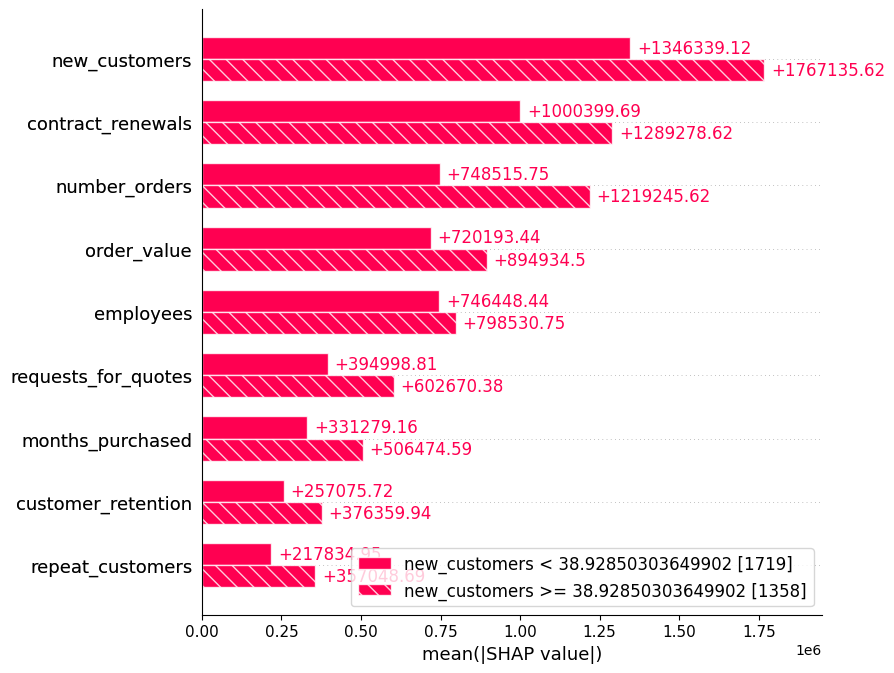

In [37]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

### Partial plots

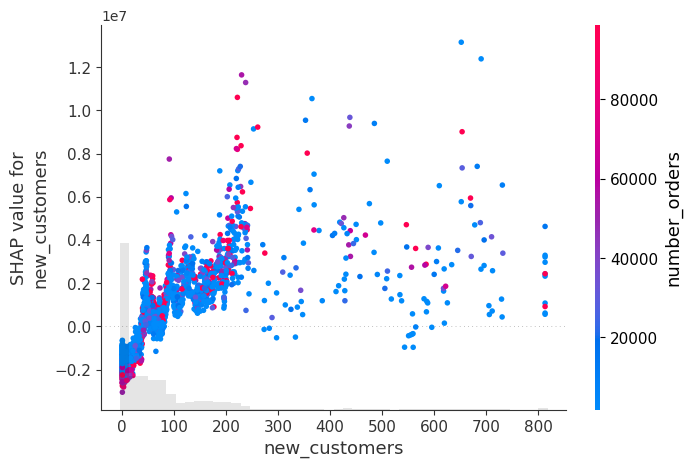

In [92]:

shap.plots.scatter(shap_values[:,"new_customers"], color = shap_values[:,"number_orders"])

## Heatmap

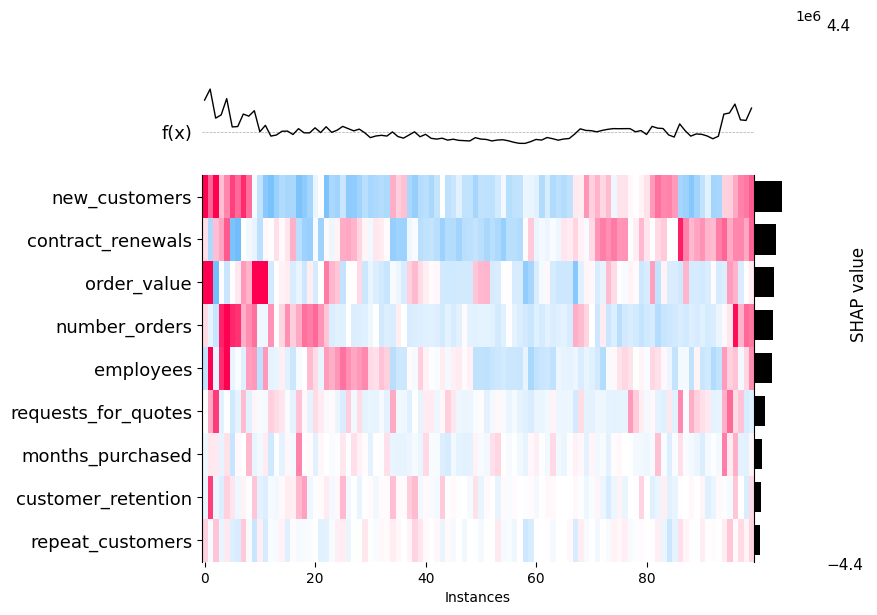

In [40]:
shap.plots.heatmap(shap_values[0:100])

## Calculate Similarity Scores Based on SHAP Values

In [41]:
# def xgb_shap_transform_scale(original_shap_values, Y_pred, which):
#     from scipy.special import expit
    
#     #Compute the transformed base value, which consists in applying the logit function to the base value
#     from scipy.special import expit #Importing the logit function for the base value transformation
#     untransformed_base_value = original_shap_values.base_values[-1]
   
#     #Computing the original_explanation_distance to construct the distance_coefficient later on
#     original_explanation_distance = np.sum(original_shap_values.values, axis=1)[which]
    
#     base_value = expit(untransformed_base_value ) # = 1 / (1+ np.exp(-untransformed_base_value))

#     #Computing the distance between the model_prediction and the transformed base_value
#     distance_to_explain = Y_pred[which] - base_value

#     #The distance_coefficient is the ratio between both distances which will be used later on
#     distance_coefficient = original_explanation_distance / distance_to_explain

#     #Transforming the original shapley values to the new scale
#     shap_values_transformed = original_shap_values / distance_coefficient

#     #Finally resetting the base_value as it does not need to be transformed
#     shap_values_transformed.base_values = base_value
#     shap_values_transformed.data = original_shap_values.data
    
#     #Now returning the transformed array
#     return shap_values_transformed    

# # CREATE SIMILARITY SCORE CSV

# #get similarity scores:
# import scipy.cluster
# import os
# from datetime import datetime
# D = scipy.spatial.distance.pdist(shap_values.values[:,:-1], 'sqeuclidean')
# clustOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))

# df_similarity = df.filter(attributes + features)
# df_similarity['similarity_score'] = clustOrder
# df_similarity = df_similarity.sort_values("similarity_score")

# # Save the results DataFrame to a CSV file
# os.makedirs(output_folder, exist_ok=True)
# output_file_path = os.path.join(output_folder, f'similarity_score_shap_{timestamp}.csv')
# df_similarity.to_csv(output_file_path, index=False)
# print(f"CSV file saved at: {output_file_path}")

# # Print the file path where the results are saved
# print("Results saved to:", file_name)

## Calculate Similarity Scores Based on Absolute Values

In [42]:
# def xgb_shap_transform_scale(original_shap_values, Y_pred, which):
#     from scipy.special import expit
    
#     #Compute the transformed base value, which consists in applying the logit function to the base value
#     from scipy.special import expit #Importing the logit function for the base value transformation
#     untransformed_base_value = original_shap_values.base_values[-1]
   
#     #Computing the original_explanation_distance to construct the distance_coefficient later on
#     original_explanation_distance = np.sum(original_shap_values.values, axis=1)[which]
    
#     base_value = expit(untransformed_base_value ) # = 1 / (1+ np.exp(-untransformed_base_value))

#     #Computing the distance between the model_prediction and the transformed base_value
#     distance_to_explain = Y_pred[which] - base_value

#     #The distance_coefficient is the ratio between both distances which will be used later on
#     distance_coefficient = original_explanation_distance / distance_to_explain

#     #Transforming the original shapley values to the new scale
#     shap_values_transformed = original_shap_values / distance_coefficient

#     #Finally resetting the base_value as it does not need to be transformed
#     shap_values_transformed.base_values = base_value
#     shap_values_transformed.data = original_shap_values.data
    
#     #Now returning the transformed array
#     return shap_values_transformed    

# # CREATE SIMILARITY SCORE CSV

# #get similarity scores:
# import scipy.cluster
# import os
# from datetime import datetime
# D = scipy.spatial.distance.pdist(shap_values.values[:,:-1], 'sqeuclidean')
# clustOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))

# df_similarity = df.filter(attributes + features)
# df_similarity['similarity_score'] = clustOrder
# df_similarity = df_similarity.sort_values("similarity_score")

# # Save the results DataFrame to a CSV file
# os.makedirs(output_folder, exist_ok=True)
# output_file_path = os.path.join(output_folder, f'similarity_score_absolute_{timestamp}.csv')
# df_similarity.to_csv(output_file_path, index=False)
# print(f"CSV file saved at: {output_file_path}")


# # Print the file path where the results are saved
# print("Results saved to:", file_name)